# Imports

In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

from tensorflow import keras
from tensorflow.keras import layers
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print(tf.config.experimental.list_physical_devices('GPU'))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import LeakyReLU
from keras.callbacks import ModelCheckpoint

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os


# Load dataset

In [2]:
X=[]
y=[]
X_test = []
y_test = []

folders = ["sample","sample296","video1","video2"]
for folder in folders:
    if not os.path.exists(f"dataset/{folder}"):
        print(f"dataset/{folder}/shots/ doesnt exist")
        continue
        
    print(f"Loading shots from dataset/{folder}/shots/")
        
    for shot_csv in tqdm(sorted(os.listdir(f'dataset/{folder}'))):
        data = pd.read_csv(os.path.join(f'dataset/{folder}', shot_csv))
        
        if folder == "video1":
            revert_data= data.copy()
            for feature in data.columns:
                if feature[-2:]=="_x":
                    revert_data[feature] = 1 - data[feature]
            data = revert_data
            
        data_train = data[:int(0.8*len(data))]
        data_test = data[int(0.8*len(data)):]

        #print(f"{len(data_train)} for training and {len(data_test)} for test")

        #print(list(data_train.loc[:, data.columns != 'shot'].to_numpy()))
        features_train = list(data_train.loc[:, data.columns != 'shot'].to_numpy())
        features_test = list(data_test.loc[:, data.columns != 'shot'].to_numpy())
        
        #print(features_train)

        X.extend(features_train)
        y.extend(data_train["shot"].to_numpy().flatten())

        X_test.extend(features_test)
        y_test.extend(data_test["shot"].to_numpy().flatten())
        
    

X = np.stack(X, axis=0)

y = np.array(y)
X = np.array(X)

y_test = np.array(y_test)

print(f"Loaded {len(y)} shots for training")
print(f"Loaded {len(y_test)} shots for test")
    

Loading shots from dataset/sample/shots/


100%|██████████| 13/13 [00:00<00:00, 19.59it/s]


Loading shots from dataset/sample296/shots/


100%|██████████| 207/207 [00:04<00:00, 47.43it/s]


Loading shots from dataset/video1/shots/


100%|██████████| 99/99 [00:02<00:00, 37.52it/s]


Loading shots from dataset/video2/shots/


100%|██████████| 143/143 [00:02<00:00, 57.53it/s]

Loaded 11088 shots for training
Loaded 2772 shots for test


# Shot shots proportion in dataset

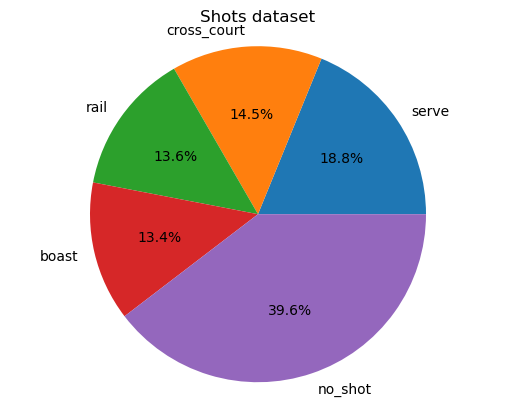

In [3]:
# if using a Jupyter notebook, include:
%matplotlib inline

shots = list(set(y))
occurences = [np.count_nonzero(y == shot) for shot in shots]
#print(shots, occurences)

fig, ax = plt.subplots()
ax.pie(occurences, labels=shots, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Shots dataset')


plt.show()

In [5]:
# # Take backhand occurences and cap all other classes to this value

# target_occurences_per_class = np.count_nonzero(y == "backhand")
# subset_indices = []
# for shot in shots:
#     indices = np.argwhere(y == shot)
#     size_subset = min(target_occurences_per_class, len(indices))
#     assert(len(indices)>= size_subset)
#     subset_indices.extend((np.random.choice(indices[:, 0], size=size_subset)))
    
# subset_indices = np.sort(subset_indices)

# y = y[subset_indices]
# X = X[subset_indices]

# occurences = [np.count_nonzero(y == shot) for shot in shots]

# fig, ax = plt.subplots()
# ax.pie(occurences, labels=shots, autopct='%1.1f%%')
# ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
# ax.set_title('Shots dataset')


# plt.show()


# Make training/validation datasets

In [6]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, shuffle= False)

print(f"Shape of train features : {X_train[0].shape}")
print(f"Shape of val features : {X_val[0].shape}")


print("Total categories: ", len(np.unique(y_train)))
print("Total categories: ", len(np.unique(y_val)))

nb_cat = len(np.unique(y_train))

Shape of train features : (26,)
Shape of val features : (26,)
Total categories:  5
Total categories:  4


In [7]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=nb_cat)
y_val = tf.keras.utils.to_categorical(y_val, num_classes=nb_cat)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=nb_cat)

y_train = np.array(y_train)
X_train = np.array(X_train)

y_val = np.array(y_val)
X_val = np.array(X_val)

y_test = np.array(y_test)
X_test = np.array(X_test)

In [8]:
print(list(le.classes_))

['boast', 'cross_court', 'no_shot', 'rail', 'serve']


In [9]:
print("X_train Shape: ", X_train.shape)
print("X_val Shape: ", X_val.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_val Shape: ", y_val.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (8316, 26)
X_val Shape:  (2772, 26)
X_test Shape:  (2772, 26)
y_train Shape:  (8316, 5)
y_val Shape:  (2772, 5)
y_test Shape:  (2772, 5)


# Build fully connected layers network

In [10]:
m1=Sequential()
m1.add(Dense(units=16,activation = 'relu', input_shape=(26,)))
#m1.add(Dropout(0.5))
m1.add(Dense(units=8,activation = 'relu', input_shape=(26,)))
#m1.add(Dropout(0.5))
m1.add(Dense(units = 8, activation = 'relu'))
m1.add(Dense(units = nb_cat, activation = 'softmax'))

c:\Users\Umais\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
m1.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])
m1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 685 (2.68 KB)

 Trainable params: 685 (2.68 KB)

 Non-trainable params: 0 (0.00 B)

# Training

In [12]:
filepath = "weights.hdf5.keras"
checkpointer = ModelCheckpoint(filepath=filepath, verbose=False, save_best_only=True)
hist = m1.fit(X_train, y_train,
               validation_data=(X_val, y_val),
               batch_size = 8,
                epochs=300, 
                verbose = 1, 
                callbacks=[checkpointer])

loss, accuracy = m1.evaluate(X_val, y_val)
print(f"Accuracy on validation dataset = {accuracy}")

Epoch 1/300
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.3344 - loss: 1.5604 - val_accuracy: 0.0519 - val_loss: 1.8079
Epoch 2/300
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3570 - loss: 1.5377 - val_accuracy: 0.0519 - val_loss: 1.7818
Epoch 3/300
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3504 - loss: 1.5305 - val_accuracy: 0.0519 - val_loss: 1.8662
Epoch 4/300
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3495 - loss: 1.5236 - val_accuracy: 0.0519 - val_loss: 1.7856
Epoch 5/300
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3369 - loss: 1.5294 - val_accuracy: 0.0559 - val_loss: 1.8233
Epoch 6/300
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.3473 - loss: 1.5290 - val_accuracy: 0.0927 - val_loss: 1.8191
Epoch 7/300
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3477 - loss: 1.5221 - val_accuracy: 0.0880 - val_loss: 1.8513
Epoch 8/300
1040/1040 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.3480 - loss: 1

In [13]:
m1.save("fully_connected_3.h5")

In [14]:
m1.save("fc3.keras")

# Confusion matrix

In [15]:
loss, accuracy = m1.evaluate(X_test, y_test)
print(f"Accuracy on test dataset = {accuracy:.3f}")

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3823 - loss: 1.4503
Accuracy on test dataset = 0.392


In [16]:
preds = m1.predict(X_test)
test_predictions = np.argmax(preds, axis=1)

87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


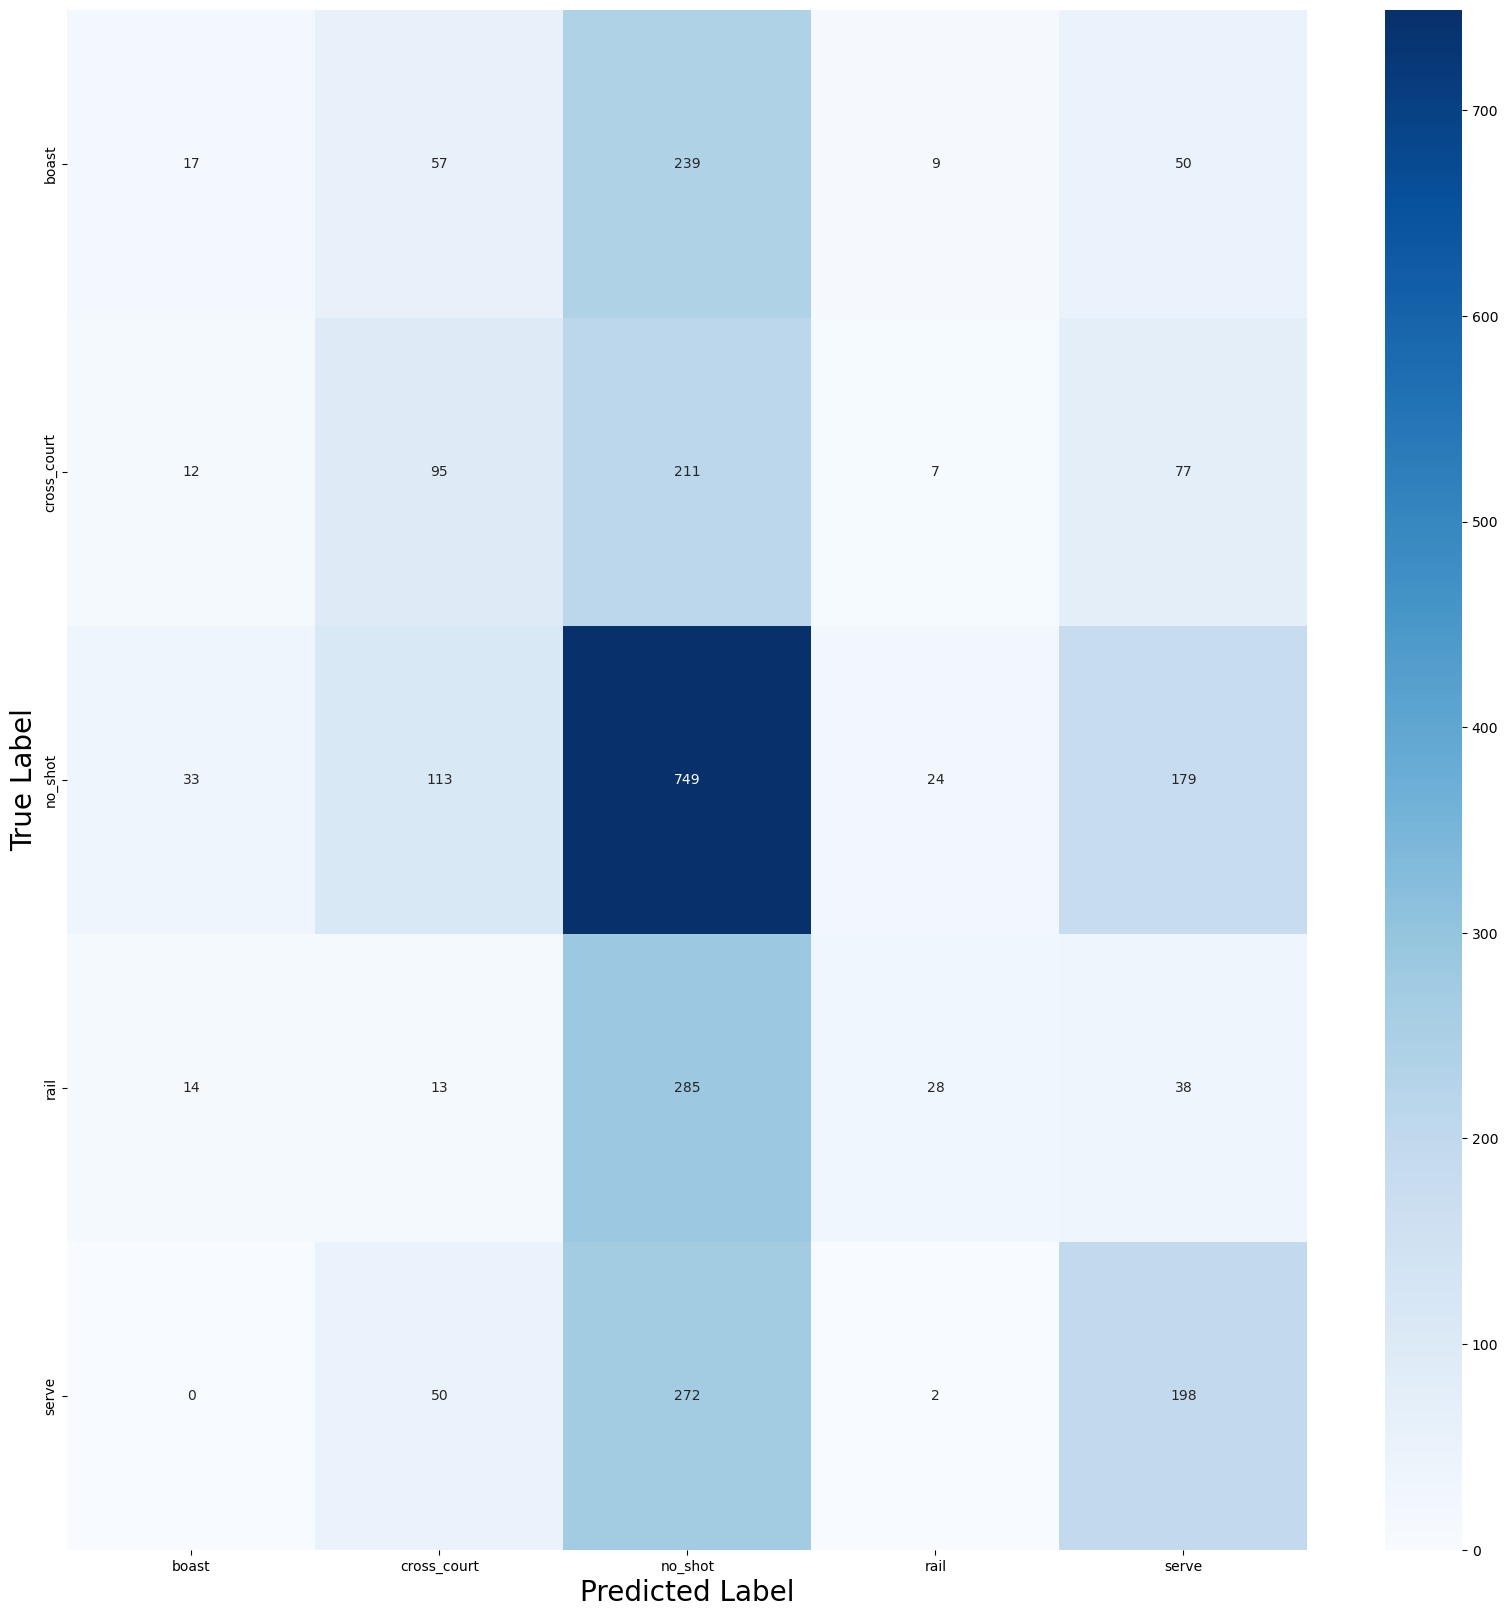

In [17]:
# Plot the confusion matrix
%matplotlib inline

cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=test_predictions)

df_cm = pd.DataFrame(
    cm, index=le.classes_, columns=le.classes_
)
plt.figure(figsize=(20, 20))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.4g')
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.show()